In [1]:
import os
import csv
import matplotlib.pyplot as plt
import requests
import numpy as np
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain.schema import AIMessage

#os.environ['http_proxy'] = 'http://wwwout.nims.go.jp:8888'
#os.environ['https_proxy'] = 'http://wwwout.nims.go.jp:8888'
os.environ['no_proxy'] = 'localhost,127.0.0.1,10.0.0.0/8,172.16.0.0/12,192.168.0.0/16,144.213.0.0/16,.nims.go.jp'
#os.environ['REQUESTS_CA_BUNDLE'] = R'C:\Users\nims_proxy.cer'
#r = requests.get('https://example.com/')


In [2]:
#Numerical parameter values
PI = 3.141592 #π
RR = 8.3145 #Gas constant [J／（mol K）]

#Setting materials and process constants
ND = 128  #Dividing number in the difference method

#c0 = 0.5 #Alloy composition （moll fraction of Cr）
al = 100.0*1.e-9 #Side length of 2-dimensional simulation area [m]
b1 = al/ND #1 block size in the difference method [m]

#These are not a real time but an increment
itime1 = 0 #Initial time ）
itime1max = 10000 + 1 #Time to stop the simulation
itime1_step = 1000 #Time step to save the field data

#Fluctuation factor
c_flu_ini=0.01 #Fluctuation factor in initial field
c_flu=0.0 #Fluctuation factor in dcdt

#Output folder
output_folder = "Phase_decomp_RSA_out/"  #RSA:Regular Solution Approximation
os.makedirs(output_folder, exist_ok=True)


In [3]:
# Definition of tool
@tool
# Definition of tool
def Check_phase_field_simulation(aging_temp1: float, alloy_comp1: float, time_step1: float)-> int:
    """
    This is a check version of the simulation.
    Performs a phase-field simulation of phase decomposition in A-B binary alloy with regular solution approximation during isothermal aging.
    It receives three input parameters: aging temperature with the unit K, alloy composition with atomic fraction B component,
    and dimensionless time step. 
    The phase-field simulation is performed, and the calculation results (simulated field images) are displied on screen. 
    Finally, it returns the end status of the calculation as an int type. When the value of the end status is 0, the calculation fails, 
    and when the value of the end status is 1, the calculation succeeds.

    Args:
        temp1 (float): temperature, a float type input parameter, unit is K.
        comp1 (float): alloy composition, a float type input parameter, atomic fraction of B component.
        time_step1 (float): time step, a float type input parameter, dimensionless value.

    Returns:
        iflg (int): end status of the calculation.
    """
    
    temp=aging_temp1  
    c0=alloy_comp1 
    delt=time_step1 

    Rtemp = RR*temp # ＲＴ [J/mol]
 
    iflg=0    

    L0=25000.0/Rtemp #Interaction parameter [J/mol]
    kappa = 5.0e-15/b1** 2/Rtemp #Composition gradient energy coefficient, Normalized to b1 and RT[Jm^2/mol]/b1^2/RT]
    Mc=c0*(1.0-c0) #Mobility of atomic diffusion (dimensionless)

    #Simulation of spinodal decomposition
    c2 = c0 + c_flu_ini*(2.0*np.random.rand(ND, ND)-1.0)  #Initial field setting

    for itime1 in range(itime1max):  #loop
        c1 =1.0 - c2
        time1=delt*itime1 #time（dimensionless）

        mu_chem=L0*(c1-c2)+np.log(c2)-np.log(c1) #chemical potential difference
        mu_grad=-2.0*kappa*(np.roll(c2,1,0) + np.roll(c2,-1,0) + np.roll(c2,1,1) + np.roll(c2,-1,1) - 4.0*c2) #Concentration gradient potential
        mu = mu_chem+mu_grad
        mu_dev = np.roll(mu,1,0) + np.roll(mu,-1,0) + np.roll(mu,1,1) + np.roll(mu,-1,1) - 4.0*mu

        dcdt = Mc*mu_dev  #Nonlinear diffusion equation
        c2n = c2 + ( dcdt+ c_flu*(2.0*np.random.rand(ND)-1.0) )*delt  #Explicit-difference method
        res = c2n - (np.mean(c2n) - c0)  #Correction for average composition
        c2 = np.clip(res, 1.0e-06, 1.0-1.0e-06)  #Correction of composition range

        #Drawing field data
        if(itime1 % itime1_step) == 0:
            print('time =', time1)
            plt.clf() #clear drawing area
            plt.axis("off")
            plt.imshow(c2)  #Drawing composition field
            plt.clim(0, 1)  #Maximum and minimum color scale settings
            plt.pause(1.0)  #displayed for 1.0 sec
            #------------------------
            iflg=1
            
    return iflg

In [4]:
# Definition of tool
@tool
def Save_phase_field_simulation(index: int, aging_temp1: float, alloy_comp1: float, time_step1: float)-> int:
    """
    This is a save version of the simulation.
    Performs a phase-field simulation of phase decomposition in A-B binary alloy with regular solution approximation during isothermal aging.
    It receives four input parameters: file_index, aging temperature with the unit K, alloy composition with atomic fraction B component,
    and dimensionless time step. 
    The phase-field simulation is performed, and the calculation results (numerical information of the composition field) is saved on hard-disk drive. 
    Finally, it returns the end status of the calculation as an int type. When the value of the end status is 0, the calculation fails, 
    and when the value of the end status is 1, the calculation succeeds.

    Args:
        index (int): file index, an integer type input parameter.
        temp1 (float): temperature, a float type input parameter, unit is K.
        comp1 (float): alloy composition, a float type input parameter, atomic fraction of B component.
        time_step1 (float): time step, a float type input parameter, dimensionless value.

    Returns:
        iflg (int): end status of the calculation.
    """
    
    np.random.seed(index)

    temp=aging_temp1  
    c0=alloy_comp1 
    delt=time_step1 #delt = 0.2 #time increment [dimensionless]

    Rtemp = RR*temp # ＲＴ [J/mol]

    text_temp = str(temp)
    text_comp = str(c0)
    text_delt = str(delt)
    text_index = str(index)
    
    filename0 = f"PF_T{text_temp}_c{text_comp}_dt{text_delt}_No{text_index}"
    filename = f"{filename0}.csv"
    path = "./"+output_folder+filename

    iflg=0    

    L0=25000.0/Rtemp #Interaction parameter [J/mol]
    kappa = 5.0e-15/b1** 2/Rtemp #Composition gradient energy coefficient, Normalized to b1 and RT[Jm^2/mol]/b1^2/RT]
    Mc=c0*(1.0-c0) #Mobility of atomic diffusion (dimensionless)

    #Simulation of spinodal decomposition
    c2 = c0 + c_flu_ini*(2.0*np.random.rand(ND, ND)-1.0)  #Initial field setting

    for itime1 in range(itime1max):  #loop
        c1 =1.0 - c2
        time1=delt*itime1 #time（dimensionless）

        mu_chem=L0*(c1-c2)+np.log(c2)-np.log(c1) #chemical potential difference
        mu_grad=-2.0*kappa*(np.roll(c2,1,0) + np.roll(c2,-1,0) + np.roll(c2,1,1) + np.roll(c2,-1,1) - 4.0*c2) #Concentration gradient potential
        mu = mu_chem+mu_grad
        mu_dev = np.roll(mu,1,0) + np.roll(mu,-1,0) + np.roll(mu,1,1) + np.roll(mu,-1,1) - 4.0*mu

        dcdt = Mc*mu_dev  #Nonlinear diffusion equation
        c2n = c2 + ( dcdt+ c_flu*(2.0*np.random.rand(ND)-1.0) )*delt  #Explicit-difference method
        res = c2n - (np.mean(c2n) - c0)  #Correction for average composition
        c2 = np.clip(res, 1.0e-06, 1.0-1.0e-06)  #Correction of composition range

        #Save composition field
        if(itime1 % itime1_step) == 0:
            file = open(path, "a", newline='')
            writer0 = csv.writer(file, delimiter=',')
            writer0.writerow([time1])
            writer0.writerows(c2)
            file.close() #save_data(time1, c2)
            #------------------------
            iflg=1 #The field data is saved

    return iflg

In [5]:
# Definition of tool
@tool
def Load_data_display_images(Fname: str)-> int:
    """
    This is the image display version of simulated data.
    It receives the file name with string type, then load the simulated data from the hard disk drive and display images.
    Finally, it returns the end status of the imaging process as an int type. When the value of the end status is 0, the process fails, 
    and when the value of the end status is 1, the process succeeds.

    Args:
        Fname (str): file name, a str type input parameter.

    Returns:
        iflg (int): end status of the process.
    """
    
    iflg=0    
    rows = []

    filename = f"{Fname}.csv"
    path = "./"+output_folder+filename
    file = open(path, "r")
    reader0 = csv.reader(file, delimiter=',')
   
    i=0
    for row in reader0:
        rows.append(row);  i+=1
    Ndata=int(i/(ND+1))

    time0 = []
    cc = np.zeros((Ndata, ND, ND))
    for ii in range (Ndata):
        iii=ii*(ND+1)
        time0.append(float(rows[iii][0]))
        for i in range (ND):
            for j in range (ND):
                cc[ii][i][j] = (float(rows[iii+i+1][j]))

    for i in range (Ndata):
        time1 = time0[i]
        c = cc[i,:,:]

        print('time =', time1)
        plt.clf() # 描画内容クリア
        plt.imshow(c)  # 濃度場の描画
        plt.axis('off') 
        plt.clim(0, 1)  # カラースケールの最大、最小の設定
        plt.pause(1.0)  # 1.0秒間表示             
        iflg=1

    return iflg

In [6]:
# Definition of tool
@tool
def Load_data_save_images(Fname: str)-> int:
    """
    This is the image saving version of simulated data.
    It receives the file name with string type, then load the simulated data from the hard disk drive and save each image as an image file.
    Finally, it returns the end status of the imaging process as an int type. When the value of the end status is 0, the process fails, 
    and when the value of the end status is 1, the process succeeds.

    Args:
        Fname (str): file name, a str type input parameter.

    Returns:
        iflg (int): end status of the process.
    """
    
    iflg=0    
    rows = []

    filename = f"{Fname}.csv"
    path = "./"+output_folder+filename
    file = open(path, "r")
    reader0 = csv.reader(file, delimiter=',')
   
    i=0
    for row in reader0:
        rows.append(row);  i+=1
    Ndata=int(i/(ND+1))

    time0 = []
    cc = np.zeros((Ndata, ND, ND))
    for ii in range (Ndata):
        iii=ii*(ND+1)
        time0.append(float(rows[iii][0]))
        for i in range (ND):
            for j in range (ND):
                cc[ii][i][j] = (float(rows[iii+i+1][j]))

    for i in range (Ndata):
        time1 = time0[i]
        c = cc[i,:,:]

        print('time =', time1)
        plt.clf() # 描画内容クリア
        plt.imshow(c)  # 濃度場の描画
        plt.axis('off') 
        plt.clim(0, 1)  # カラースケールの最大、最小の設定

        fname="./"+output_folder+"image"+Fname+"_"+str(time1).replace(".", "")+".jpg"
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.0)
        plt.pause(1.0)  # 1.0秒間表示     
        iflg=1

    return iflg

In [7]:
tools = [Check_phase_field_simulation, Save_phase_field_simulation, Load_data_display_images, Load_data_save_images]
LLM = "qwen3:8b"
model = ChatOllama( 
    model=LLM, 
    temperature=0 
)
agent = create_react_agent( 
    model=model, 
    tools=tools 
)


time = 0.0


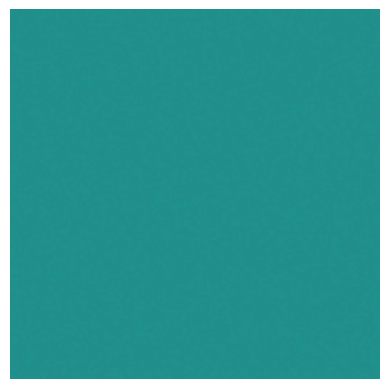

time = 20.0


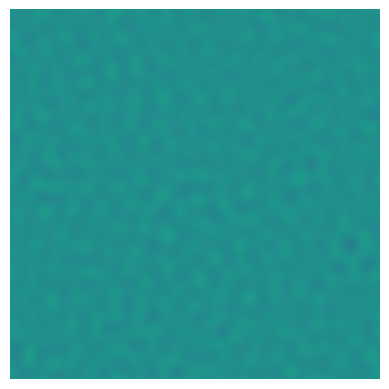

time = 40.0


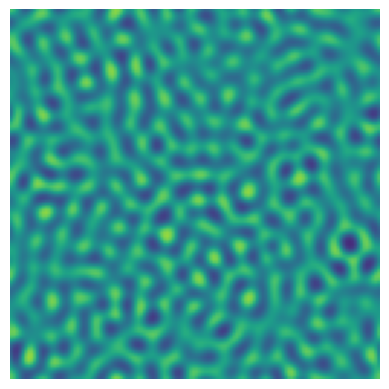

time = 60.0


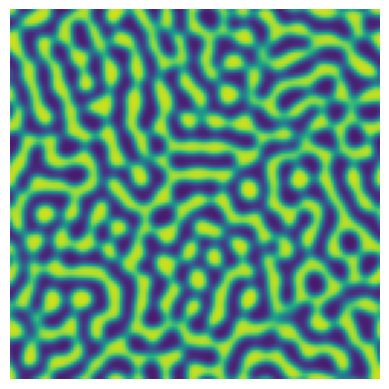

time = 80.0


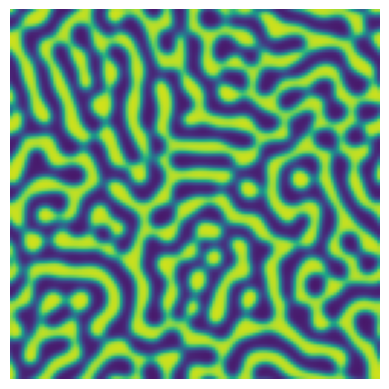

time = 100.0


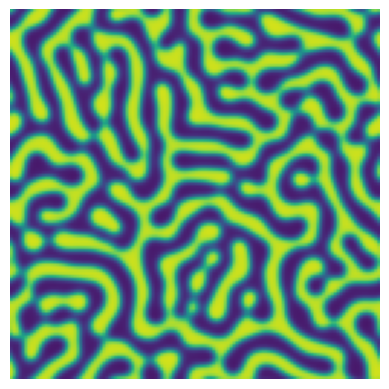

time = 120.0


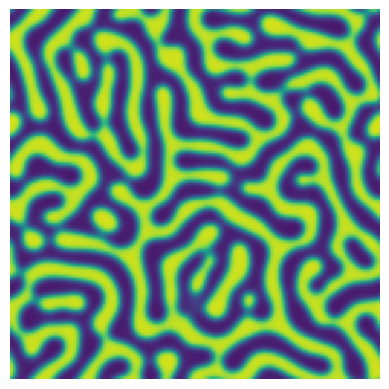

time = 140.0


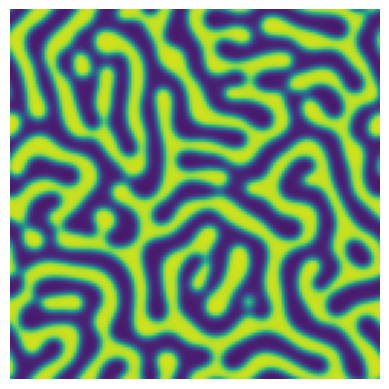

time = 160.0


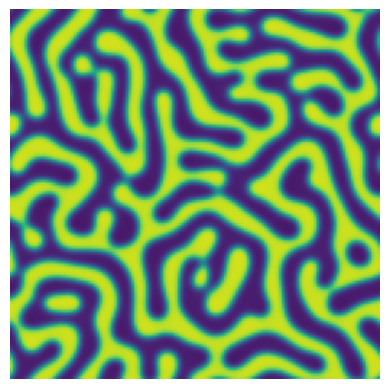

time = 180.0


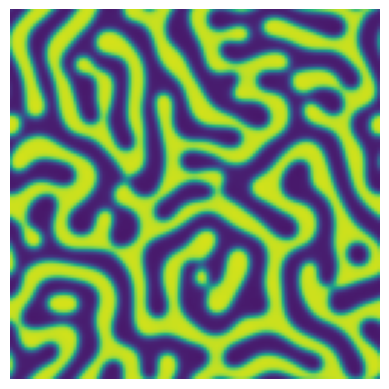

time = 200.0


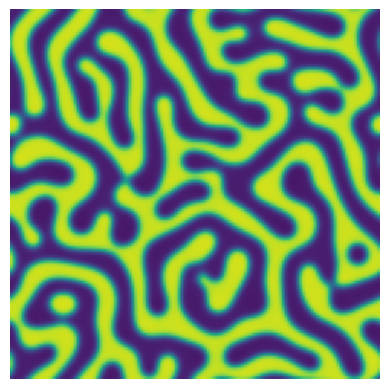


- 
- <think>
Okay, the user fixed the aging temperature at 1000 K, alloy composition at 0.5, and time step at 0.02. They ran the Check_phase_field_simulation tool with those parameters. The response was 1, which means the calculation succeeded. Now, I need to let them know it worked. Maybe they want to proceed with saving the data or viewing images. I should confirm the success and ask if they need further steps. Keep the response clear and helpful.
</think>

The phase-field simulation was successfully executed under the specified conditions:  
- **Aging Temperature**: 1000 K  
- **Alloy Composition**: 0.5 (atomic fraction of B)  
- **Time Step**: 0.02  

The calculation completed without errors (return status: `1`). Would you like to save the results or visualize the simulated fields next?


In [8]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """Fix the aging temperature at 1000 K, fix the alloy composition to 0.5, and fix the time step to 0.02. 
               Under the above conditions, run the tool:'Check_phase_field_simulation'."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)


In [9]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """Fix the index number to 1, fix the aging temperature at 1000 K, and fix the time step to 0.02. 
               Under the above conditions, repeat the tool: 'Save_phase_field_simulation' while changing the alloy composition from 0.35 to 0.45 in increments of 0.05."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)



- 
- <think>
Okay, the user wants me to fix the index at 1, aging temperature at 1000 K, and time step at 0.02. Then, they want to run the Save_phase_field_simulation tool with alloy compositions from 0.35 to 0.45 in increments of 0.05. 

First, I need to check the parameters. The alloy compositions should be 0.35, 0.4, and 0.45. Each call to Save_phase_field_simulation needs the index, temp, comp, and time step. Since the user specified the index as 1, I'll use that for each call. The temperature and time step are fixed, so they remain the same in all three function calls.

I should make sure that the parameters are correctly formatted as per the function's required arguments. The function requires index (integer), aging_temp1 (float), alloy_comp1 (float), and time_step1 (float). All these are provided in each call. 

The user also mentioned repeating the tool while changing the composition. So, three separate function calls are needed. Each with the respective comp value. The respon

In [10]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """Fix the aging temperature at 1000 K, fix the alloy composition to 0.5, and fix the time step to 0.02. 
               Under the above conditions, repeat the tool: 'Save_phase_field_simulation' with increasing the file index from 1 to 10 by 1."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)



- 
- <think>
Okay, the user wants me to fix the aging temperature at 1000 K, alloy composition at 0.5, and time step at 0.02. Then, repeat the Save_phase_field_simulation tool with file indices from 1 to 10. 

First, I need to check the parameters for Save_phase_field_simulation. The required parameters are index, aging_temp1, alloy_comp1, and time_step1. The user provided all the values except the index, which should increment from 1 to 10.

So, I'll generate 10 function calls, each with the same temp, comp, and time step, but increasing the index from 1 to 10. Each call should have those parameters. The previous assistant did exactly that, and the responses were all 1, indicating success. 

Now, the user might want confirmation that all simulations were saved successfully. Since each call returned 1, I should inform them that all 10 simulations were saved without issues. Maybe they need to proceed to the next step, like loading the data or displaying images. I should offer further a

time = 0.0


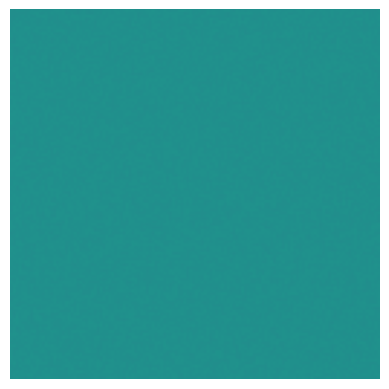

time = 20.0


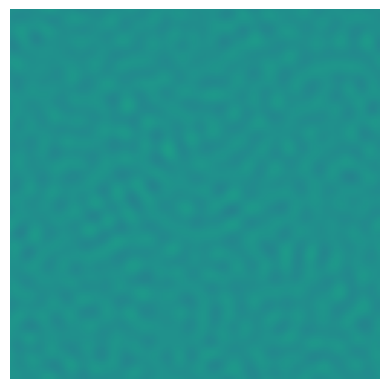

time = 40.0


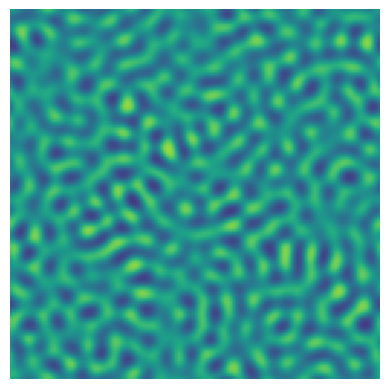

time = 60.0


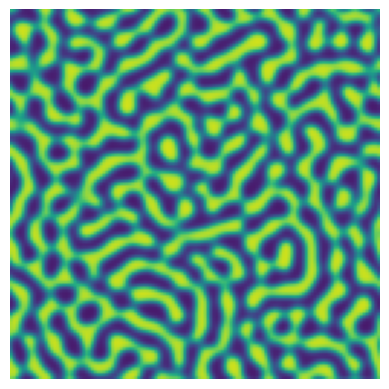

time = 80.0


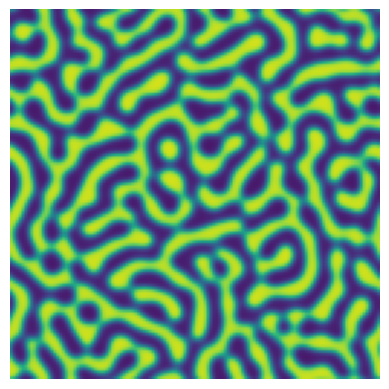

time = 100.0


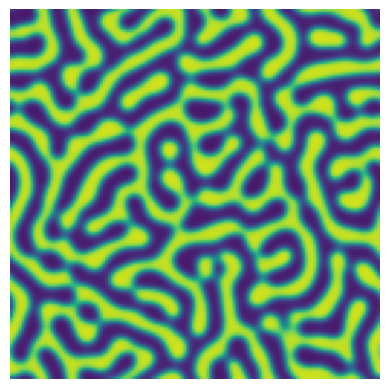

time = 120.0


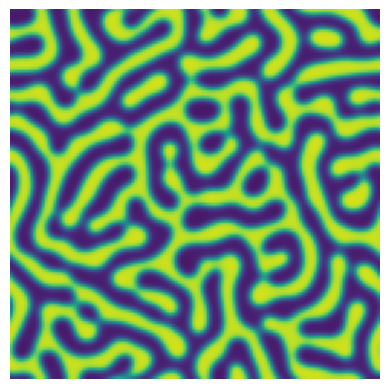

time = 140.0


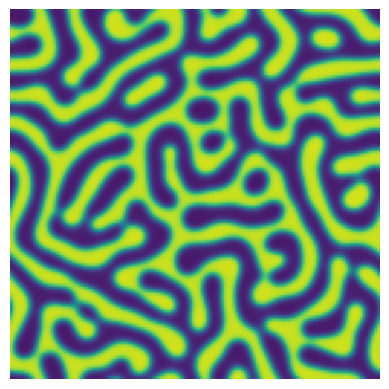

time = 160.0


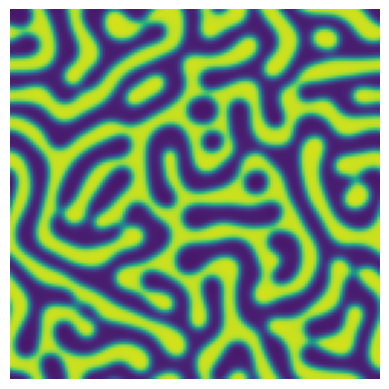

time = 180.0


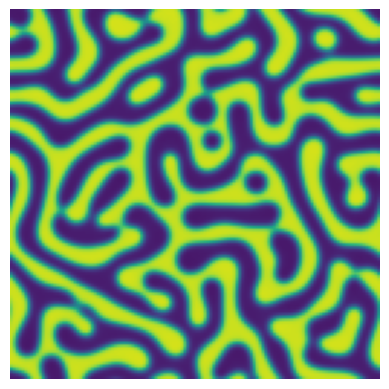

time = 200.0


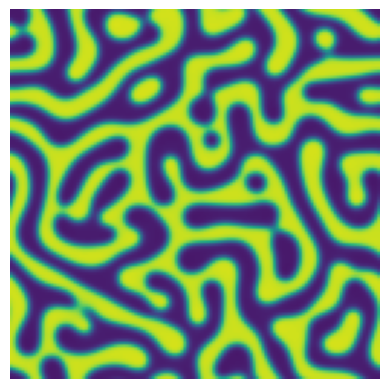


- 
- <think>
Okay, the user provided a file name "PF_T1000.0_c0.5_dt0.02_No2" and wants to display the image data using the Load_data_display_images tool. Let me check the functions available.

The Load_data_display_images function takes a string parameter Fname. The user's file name seems valid, so I should call that function with the given filename. The response from the tool was 1, which indicates success. Now, I need to inform the user that the image was displayed successfully. I should confirm the action and mention the end status. Also, maybe offer further assistance in case they need more actions like saving images or performing simulations. Keep the response clear and concise.
</think>

The image data from the file "PF_T1000.0_c0.5_dt0.02_No2" has been successfully displayed. The process completed with status code 1 (success). 

Would you like to perform any additional operations, such as saving the images or analyzing other simulation data?


In [11]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """The file name is "PF_T1000.0_c0.5_dt0.02_No2". 
                Display the image data by using the tool:'Load_data_display_images'."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)


time = 0.0


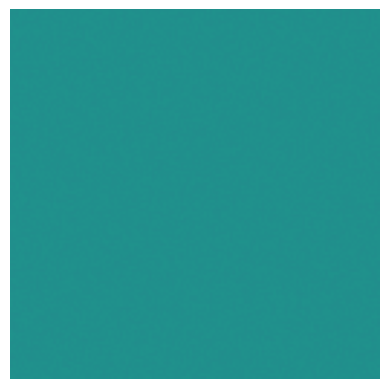

time = 20.0


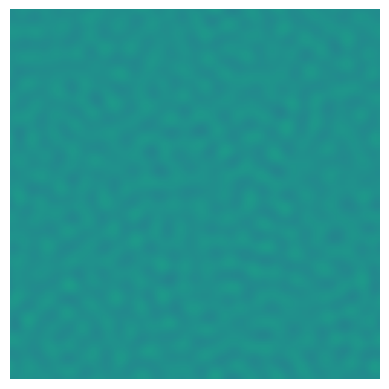

time = 40.0


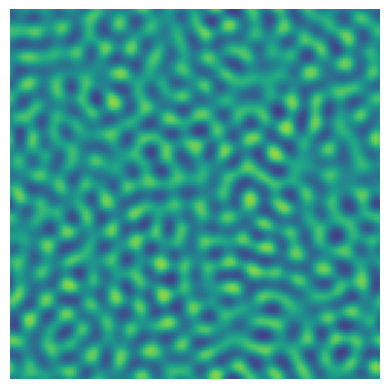

time = 60.0


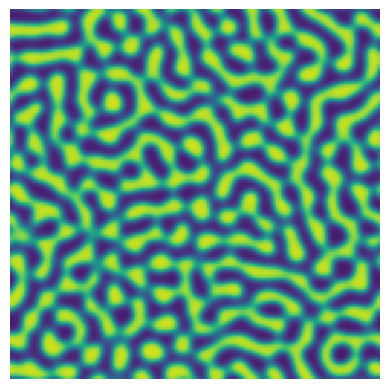

time = 80.0


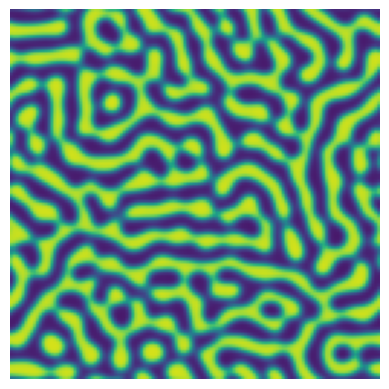

time = 100.0


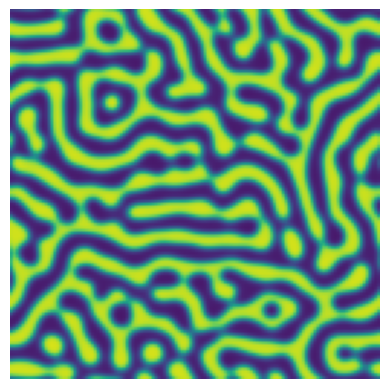

time = 120.0


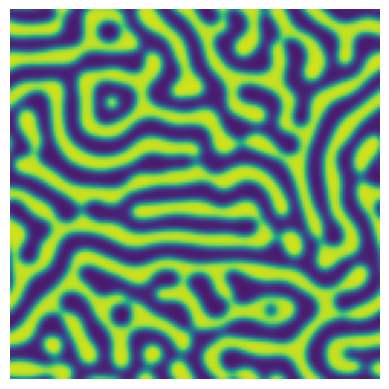

time = 140.0


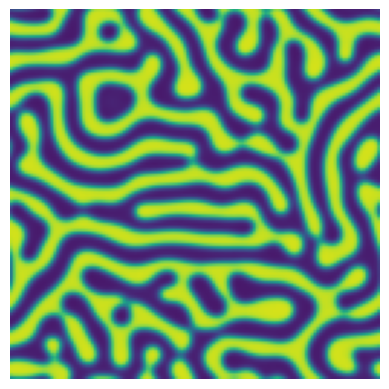

time = 160.0


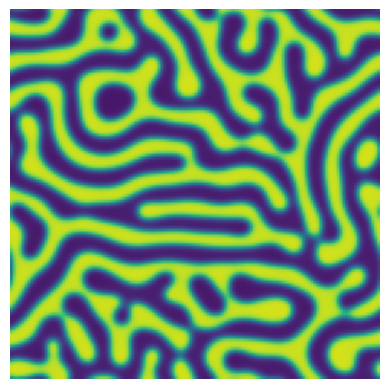

time = 180.0


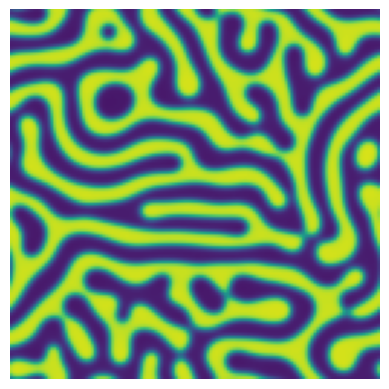

time = 200.0


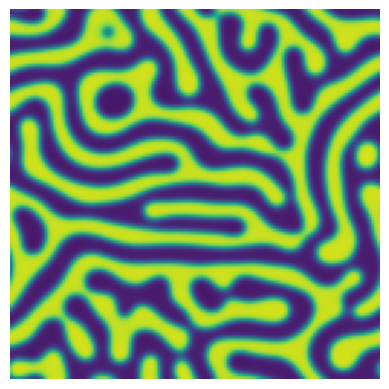


- 
- <think>
Okay, the user provided a file name "PF_T1000.0_c0.5_dt0.02_No3" and wants to save the image data using the Load_data_save_images tool. Let me check the functions available.

The Load_data_save_images function takes a file name as a string argument. The user already provided the file name, so I just need to pass it correctly. The parameters require "Fname" as a string. The previous tool call used this function with the given file name, and the response was 1, which indicates success. Now, the user probably expects confirmation that the images were saved successfully. I should respond in Korean, stating that the process succeeded and the images are saved. Make sure the message is clear and confirms the action.
</think>

The image data has been successfully saved using the file name "PF_T1000.0_c0.5_dt0.02_No3". The process returned status code 1, indicating successful completion.


In [12]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """The file name is "PF_T1000.0_c0.5_dt0.02_No3". 
                Save the image data by using the tool:'Load_data_save_images'."""}]
}
answer = agent.invoke(messages)
messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)
